# Imports 

In [28]:
import pickle
import pandas as pd
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import numpy as np

import os
import sys
currentdir = os.path.dirname(os.path.realpath('results_DK'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from func import (test_train_split)
    


# Results and score dataframes

## Loading results

In [29]:
# BASELINE
# with open('results/final/baseline/results_baseline.pickle', 'rb') as handle:
#     results_baseline = pickle.load(handle)

with open('results/final/baseline/results_ar_year_lag.pickle', 'rb') as handle:
    results_baseline = pickle.load(handle)

#LASSO
with open('results/final/lasso/results_final.pickle', 'rb') as handle:
    results_lasso = pickle.load(handle) 

#RIDGE
with open('results/final/ridge/results_final.pickle', 'rb') as handle:
    results_ridge = pickle.load(handle) 

# #ELASTIC
with open('results/final/elastic/results_final.pickle', 'rb') as handle:
    results_elastic = pickle.load(handle) 
    
# #RANDOM FOREST
with open('results/final/randomforest/results_final_noint.pickle', 'rb') as handle:
    results_randomforest = pickle.load(handle) 

#XGBOOST
with open('results/final/xgboost/results_final_noint.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)     

#WEIGHTED
with open('results/final/weighted/results_final.pickle', 'rb') as handle:
    results_weighted = pickle.load(handle)
    
    
#Adding nan so lenghts match
results_weighted[1] = {'w': np.nan,
 'best_rmse': np.nan,
 'y_pred': np.nan,
 'best_y_pred_rmse': np.nan,
 'y_actual': np.nan}

#DATA
df_analysis = pd.read_csv('data/descriptive/df_analysis.csv', sep = ',', parse_dates = ['date'])

#SETTINGS FOR MODELS
window = 11
testsize = 1
valsize = 1
rolling_window = True
params = []

# TEST DATES FOR EACH WINDOW
with open('results/final/y_dates.pickle', 'rb') as handle:
    y_dates = pickle.load(handle)

In [30]:
y_dates[1].shape

(20, 1)

## Constructing dataframes

### df_results for predictions


y_dates in correct format

In [31]:
df_results = df_analysis[['ID', 'date', 'target_actual']].copy()

df_results = df_results[~(df_results['ID'] =='Jämtland')]

#1st diff
df_results['target_diff'] = df_results.groupby('ID')['target_actual'].diff()

In [32]:
df_results['ID'].value_counts()

Östergötland        51
Gotland             51
Värmland            51
Västerbotten        51
Västra Götalands    51
Örebro              51
Norrbotten          51
Jönköping           51
Halland             51
Skåne               51
Stockholm           51
Kalmar              51
Gävleborg           51
Uppsala             51
Västernorrland      51
Kronoberg           51
Södermanland        51
Blekinge            51
Västmanland         51
Dalarna             51
Name: ID, dtype: int64

In [33]:
df_results['date'] = df_results.set_index('date').index.to_period('Q')

In [34]:
for win in y_dates.keys():
    
    #BACKGROUND
    y_dates[win]['ID'] = df_results['ID']
    y_dates[win]['win'] = win
    y_dates[win]['target_level'] = df_results['target_actual']
    y_dates[win]['target_diff'] = df_results['target_diff']
    
    
    #BASELINE RESULTS
    y_dates[win]['baseline_pred_diff'] = results_baseline[win]['y_pred_dict']['OLS']
    
    #LASSO
    y_dates[win]['lasso_pred_diff'] = results_lasso[win]['best_y_pred_rmse']
    
    #RIDGE
    y_dates[win]['ridge_pred_diff'] = results_ridge[win]['best_y_pred_rmse']
    
    #ELASTIC
    y_dates[win]['elastic_pred_diff'] = results_elastic[win]['best_y_pred_rmse']
    
    #RANDOM FOREST
    y_dates[win]['randomforest_pred_diff'] = results_randomforest[win]['best_y_pred_rmse']
    
    #XGBOOST
    y_dates[win]['xgboost_pred_diff'] = results_xgboost[win]['best_y_pred_rmse']  
    
    #WEIGHTED
    y_dates[win]['weighted_pred_diff'] = results_weighted[win]['best_y_pred_rmse']

    

#Concatting
df_pred = pd.concat(y_dates).reset_index().drop('level_0', axis = 1).set_index('level_1')

#Onto df_results
df_results = pd.merge(df_results,
         df_pred[['ID', 'date', 'win', 'baseline_pred_diff', 'lasso_pred_diff', 'ridge_pred_diff','elastic_pred_diff' ,'randomforest_pred_diff' , 'xgboost_pred_diff', 'weighted_pred_diff']], 
         how = 'left', on = ['ID', 'date']).copy()

#temp col to get level predictions
df_results['target_actual_help'] = df_results.groupby('ID')['target_actual'].shift(1)

#adding pred_diff to previous level to get pred_level
for model in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_results[model+'_pred_level'] = df_results['target_actual_help'] + df_results[model+'_pred_diff']

#Removing temp col
df_results.drop('target_actual_help', axis = 1, inplace = True)

In [35]:
pd.concat(y_dates)['ID'].value_counts()

Östergötland        34
Gotland             34
Värmland            34
Västerbotten        34
Västra Götalands    34
Örebro              34
Norrbotten          34
Jönköping           34
Halland             34
Skåne               34
Stockholm           34
Kalmar              34
Gävleborg           34
Uppsala             34
Västernorrland      34
Kronoberg           34
Södermanland        34
Blekinge            34
Västmanland         34
Dalarna             34
Name: ID, dtype: int64

In [36]:
df_pred.ID.value_counts()

Östergötland        34
Gotland             34
Värmland            34
Västerbotten        34
Västra Götalands    34
Örebro              34
Norrbotten          34
Jönköping           34
Halland             34
Skåne               34
Stockholm           34
Kalmar              34
Gävleborg           34
Uppsala             34
Västernorrland      34
Kronoberg           34
Södermanland        34
Blekinge            34
Västmanland         34
Dalarna             34
Name: ID, dtype: int64

### df_score for performance

In [37]:
#df with date and win as rows
df_score = df_results[['date', 'win']].dropna().drop_duplicates().reset_index().sort_values('date').copy()
df_score.drop('index', axis = 1, inplace = True)

In [38]:
#Baseline
df_score['baseline_rmse'] = [results_baseline[win]['best'][-1] for win in results_baseline.keys()]

#ML Models
for model, model_str in zip([results_lasso, results_ridge, results_elastic, results_randomforest, results_xgboost], ['lasso', 'ridge', 'elastic', 'randomforest', 'xgboost']):
    df_score[model_str+'_rmse'] = [model[win]['best_rmse'][-1] for win in model.keys()]

#WEIGHTED
temp = [np.nan]
df_score['weighted_rmse'] = temp + [results_weighted[win]['best_rmse'][-1] for win in results_weighted.keys() if win > 1]

In [39]:
df_score.describe().loc['mean'].round(4)

win                  17.5000
baseline_rmse         1.2296
lasso_rmse            1.2144
ridge_rmse            1.2349
elastic_rmse          1.2187
randomforest_rmse     1.1698
xgboost_rmse          1.1159
weighted_rmse         1.1586
Name: mean, dtype: float64

In [40]:
df_score.describe().loc['std'].round(4)

win                  9.9582
baseline_rmse        0.3031
lasso_rmse           0.3440
ridge_rmse           0.3536
elastic_rmse         0.3506
randomforest_rmse    0.4509
xgboost_rmse         0.3587
weighted_rmse        0.3315
Name: std, dtype: float64

### Share below baseline

In [41]:
#Relative to baseline
for model_str in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_score[model_str+'_relative'] = df_score[model_str+'_rmse'] - df_score['baseline_rmse']

In [42]:
#Relative to baseline
for model_str in ['lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_score[model_str+'_below'] = df_score[model_str+'_rmse'] < df_score['baseline_rmse']

In [43]:
(df_score[['lasso_below', 'ridge_below', 'elastic_below','randomforest_below', 'xgboost_below', 'weighted_below']].sum() / len(df_score['win'])*100).round(2)

lasso_below           58.82
ridge_below           52.94
elastic_below         58.82
randomforest_below    67.65
xgboost_below         79.41
weighted_below        67.65
dtype: float64

## Report plots

In [44]:
    # FOR PLOTS
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 15})
rc('text', usetex=True)
rc('legend',fontsize=14)


#Colors 
color_rgb = [(0.26, 0.33, 0.41), (0.00, 0.47, 0.53),(0.65, 0.65, 0.65),  (0.13, 0.50, 0.36), (0.54, 0.23, 0.23), (0.54, 0.23, 0.23)]

linewidth = 1.5

In [45]:
df_score['date'] = (df_score['date']).apply(lambda d: pd.to_datetime(str(d)))
df_results['date'] = (df_results['date']).apply(lambda d: pd.to_datetime(str(d)))

### Performance - levels

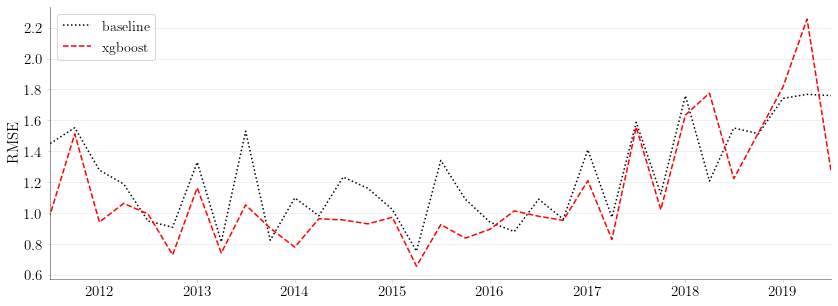

In [42]:
linewidth = 1.5

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_rmse'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
       linewidth = linewidth, linestyle = ':')

#xgboost
model = 'xgboost'
how = '_rmse'
color = 'red'

ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
       linewidth = linewidth, linestyle = '--')

ax.legend(fancybox = True)

ax.set_ylabel('RMSE')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())

# #Exporting
#plt.savefig("report/7_robustness_DK/7_score_level.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Performance - relative to baseline


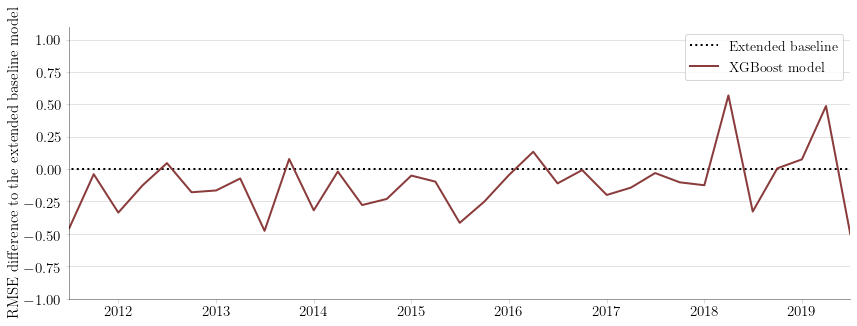

In [47]:
linewidth = 2

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_relative'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = 'Extended baseline',
       linewidth = linewidth, linestyle = ':')

# #LASSO
# model = 'lasso'
# how = '_relative'
# color = 0

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)

# #RIDGE
# model = 'ridge'
# how = '_relative'
# color = 1

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #ELASTIC
# model = 'elastic'
# how = '_relative'
# color = 2

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #RF
# model = 'randomforest'
# how = '_relative'
# color = 3

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


#XGBOOST
model = 'xgboost'
how = '_relative'
color = 4

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'XGBoost model',
      linewidth = linewidth)


# # #WEIGHTED
# model = 'weighted'
# how = '_relative'
# color = 4

# ax.plot((df_score[['date', model+how]].set_index('date')), color =  color_rgb[color], label = 'Weigthed',
#         linewidth = linewidth)#, linestyle = '--')

ax.legend(fancybox = True, loc = 1)

ax.set_ylabel('RMSE difference to the extended baseline model')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())
ax.set_ylim([-1,1.1])
# #Exporting
plt.savefig("report/8_robustness_SE/8_score_relative.pdf", bbox_inches='tight', encoding='utf-8-sig')
#plt.show()

### Predicted level for Stockholm - BASELINE


In [44]:
linewidth = 1.5

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


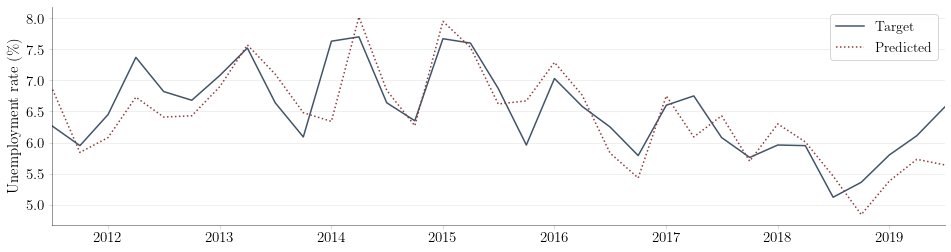

In [45]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Stockholm'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate (\%)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
#plt.savefig("report/7_results/7_pred_level_capital_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Stockholm - BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


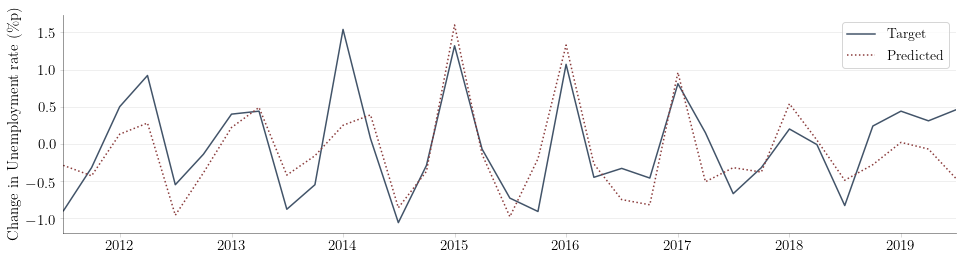

In [46]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Stockholm'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Change in Unemployment rate (\%p)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# #Exporting
#plt.savefig("report/7_results/7_pred_diff_capital_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [47]:
df_results.groupby('ID')['baseline_pred_diff'].mean()

ID
Blekinge           -0.053529
Dalarna            -0.046471
Gotland            -0.042353
Gävleborg          -0.107353
Halland            -0.132353
Jönköping          -0.077941
Kalmar             -0.184412
Kronoberg          -0.064706
Norrbotten         -0.108529
Skåne              -0.038824
Stockholm          -0.088235
Södermanland       -0.034412
Uppsala            -0.154118
Värmland           -0.151765
Västerbotten       -0.127059
Västernorrland     -0.133529
Västmanland        -0.071471
Västra Götalands   -0.117647
Örebro             -0.020000
Östergötland       -0.070882
Name: baseline_pred_diff, dtype: float64

In [48]:
df_results.groupby('ID')['weighted_pred_diff'].mean()

ID
Blekinge            0.096061
Dalarna             0.078182
Gotland            -0.064242
Gävleborg           0.069394
Halland            -0.056970
Jönköping          -0.090000
Kalmar              0.099697
Kronoberg          -0.063030
Norrbotten          0.145152
Skåne               0.088788
Stockholm           0.030303
Södermanland        0.073333
Uppsala             0.024848
Värmland            0.053939
Västerbotten       -0.005758
Västernorrland      0.069091
Västmanland         0.088788
Västra Götalands    0.048485
Örebro              0.113636
Östergötland        0.123030
Name: weighted_pred_diff, dtype: float64

### Predicted level for STOCKHOLM - XGboost


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


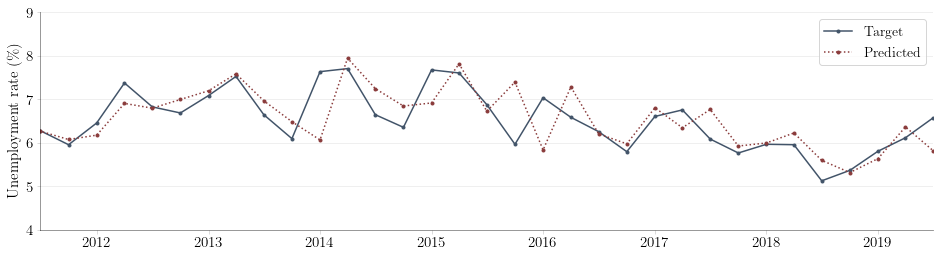

In [49]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Stockholm'
model = 'xgboost'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth, marker = '.')

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':', marker = '.')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate (\%)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)

ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([4,9])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_level_stockholm_xgboost_v_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for STOCKHOLM - XGBOOST


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


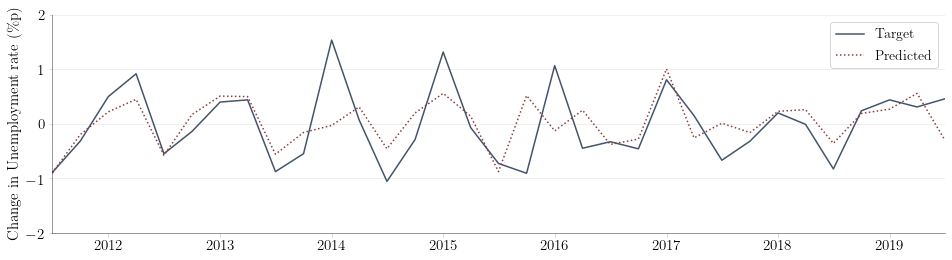

In [50]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Stockholm'
model = 'xgboost'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Change in Unemployment rate (\%p)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([-2,2])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_diff_stockholm_xgboost_v_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for Västerbotten - XGboost


In [48]:
linewidth = 2

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


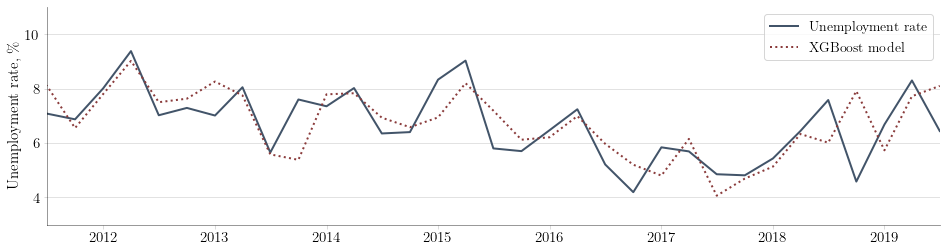

In [49]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Västerbotten'
model = 'xgboost'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'XGBoost model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)

ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([3,11])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_level_Vasterbotten_xgboost.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Västerbotten - XGBOOST


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


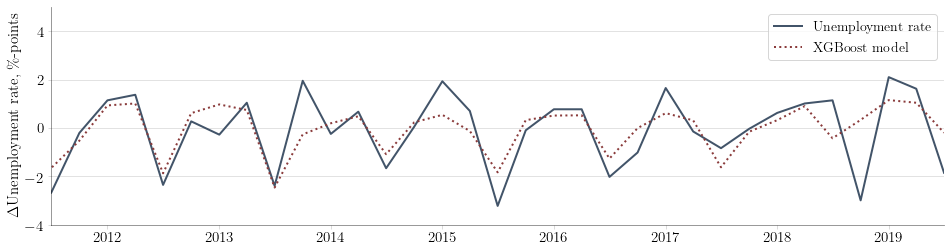

In [50]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Västerbotten'
model = 'xgboost'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'XGBoost model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([-4,5])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_diff_Vasterbotten_xgboost.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

## Fuction for diff level plots - Appendix

In [19]:
def diff_figure(geo = geo, model = model, how = how, path = path, ylim = [-4,8]):
    fig, ax = plt.subplots(figsize = (6,2))

    #TRUE
    ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
           linewidth = linewidth)

    #PREDICTED
    ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'XGBoost model',
           linewidth = linewidth)


    ax.legend(fancybox = True, fontsize=8, loc = 1)

    ax.set_ylabel('$\Delta$UE rate, \%-points')

    #Fixing box and grids
    ax.grid(b = True, axis ='y', alpha=0.45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_alpha(0.5)
    ax.spines['left'].set_alpha(0.5)
    ax.tick_params(axis='x', color = 'lightgrey')
    ax.tick_params(axis='y', color = 'lightgrey')
    ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
    ax.set_ylim(ylim)

    # #Exporting
    plt.savefig(path, bbox_inches='tight', encoding='utf-8-sig')
    plt.show()

NameError: name 'geo' is not defined

In [23]:
def level_figure(geo = geo, model = model, how = how, path = path, ylim = [3,15]):
    fig, ax = plt.subplots(figsize = (6,2))

        #TRUE
    ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
           linewidth = linewidth)

    #PREDICTED
    ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'XGBoost model',
           linewidth = linewidth)


    ax.legend(fancybox = True, fontsize=8, loc = 1)

    ax.set_ylabel('Unemployment rate, \%')

    #Fixing box and grids
    ax.grid(b = True, axis ='y', alpha=0.45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_alpha(0.5)
    ax.spines['left'].set_alpha(0.5)

    ax.tick_params(axis='x', color = 'lightgrey')
    ax.tick_params(axis='y', color = 'lightgrey')
    ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
    ax.set_ylim(ylim)

    # #Exporting
    plt.savefig(path, bbox_inches='tight', encoding='utf-8-sig')
    plt.show()

In [24]:
geo_list = df_results.ID.value_counts().index.to_list()

In [25]:
print(sorted(geo_list))

['Blekinge', 'Dalarna', 'Gotland', 'Gävleborg', 'Halland', 'Jönköping', 'Kalmar', 'Kronoberg', 'Norrbotten', 'Skåne', 'Stockholm', 'Södermanland', 'Uppsala', 'Värmland', 'Västerbotten', 'Västernorrland', 'Västmanland', 'Västra Götalands', 'Örebro', 'Östergötland']


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


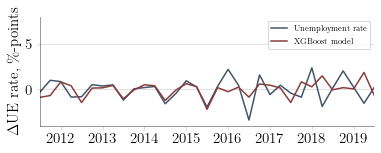

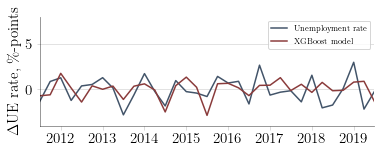

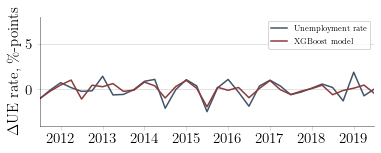

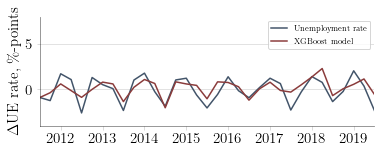

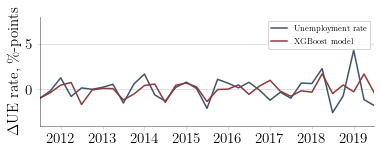

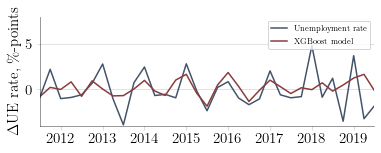

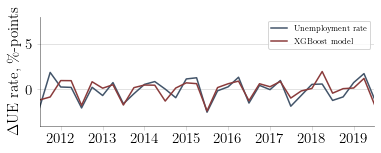

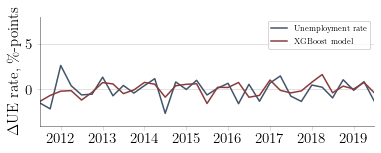

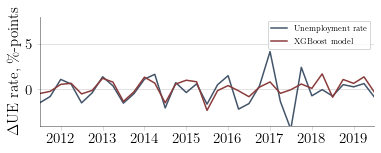

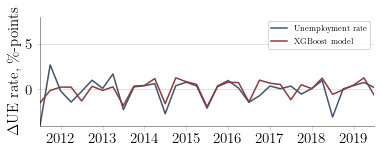

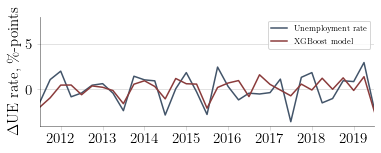

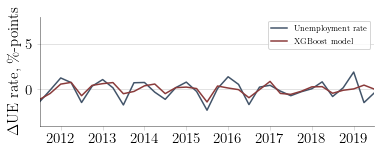

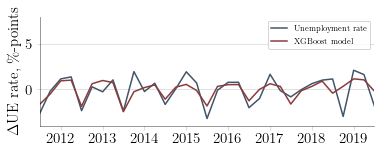

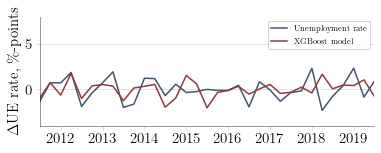

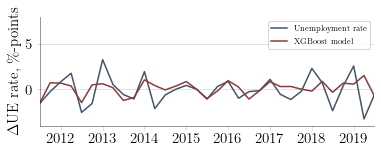

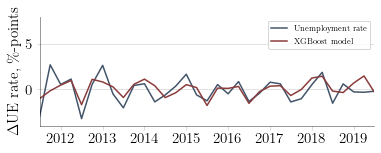

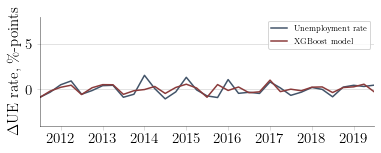

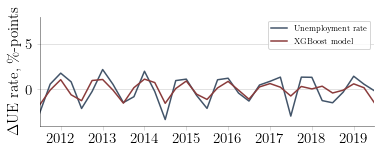

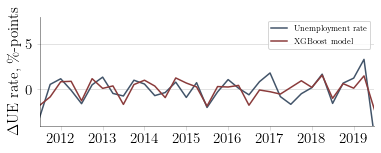

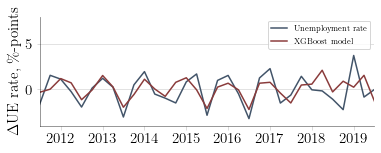

In [115]:
for i in geo_list:

    geo = i
    model = 'xgboost'
    how = '_diff'
    path = "report/8_robustness_SE/8_pred_diff_" + geo + "_xgboost.pdf"

    diff_figure(geo = geo, model = model, how = how, path = path)

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


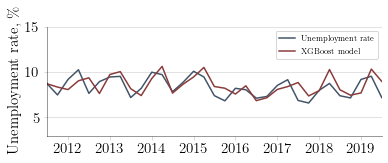

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


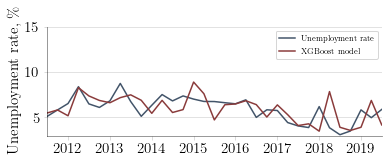

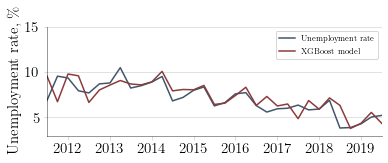

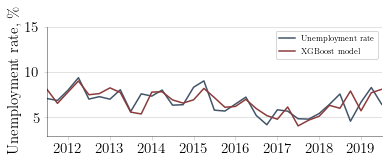

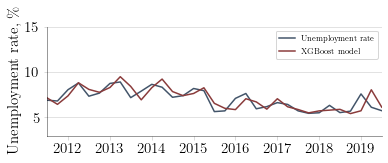

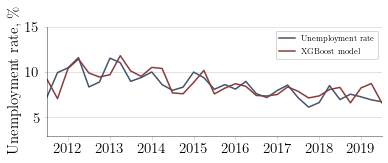

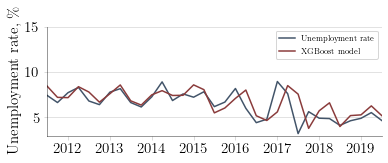

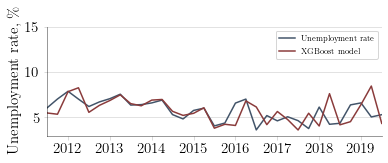

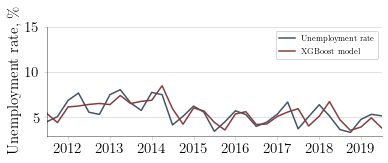

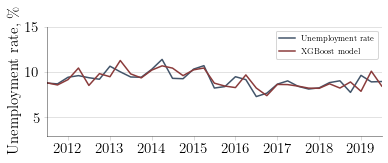

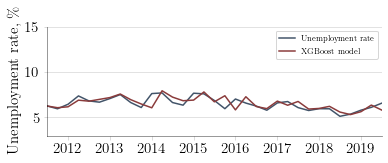

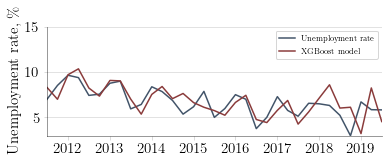

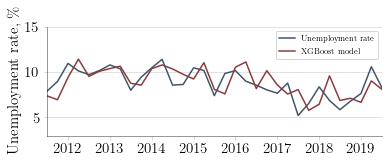

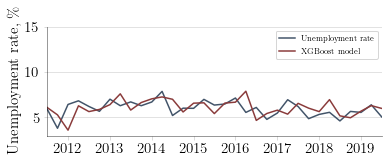

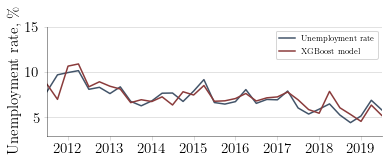

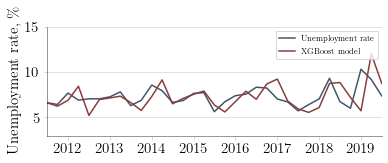

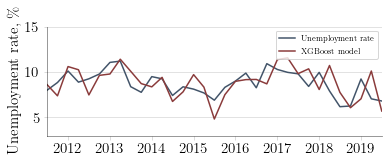

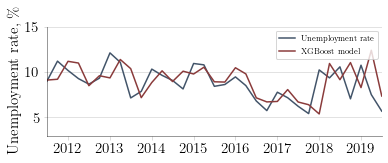

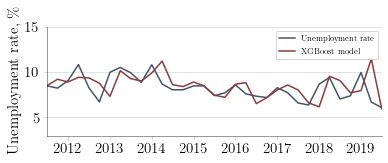

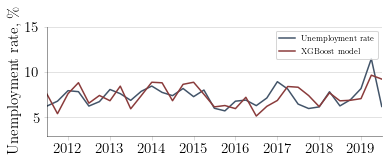

In [26]:
for i in geo_list:

    geo = i
    model = 'xgboost'
    how = '_level'
    path = "report/8_robustness_SE/8_pred_level_" + geo + "_xgboost.pdf"

    level_figure(geo = geo, model = model, how = how, path = path)

### Predicted level for Västerbotten - BASELINE


C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


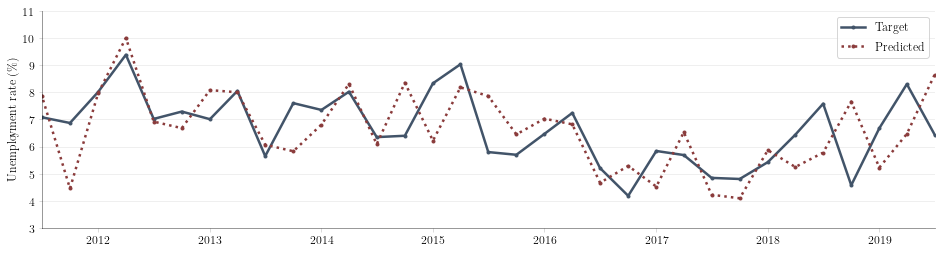

In [268]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Västerbotten'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth, marker = '.')

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':', marker = '.')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate (\%)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)

ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([3,11])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_level_Vasterbotten_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Västerbotten - BASELINE


C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


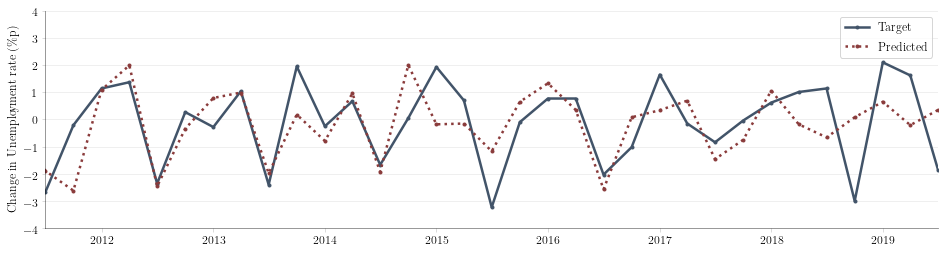

In [269]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Västerbotten'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth, marker = '.')

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':', marker='.')


ax.legend(fancybox = True)

ax.set_ylabel('Change in Unemployment rate (\%p)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim([-4,4])

# #Exporting
plt.savefig("report/8_robustness_SE/8_pred_diff_Vasterbotten_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [270]:
df_results.dropna()[['target_diff', 'date', model+'_pred'+how]][df_results['ID']==geo].set_index('date')

C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,target_diff,baseline_pred_diff
date,,
2011-07-01,-2.68,-1.89
2011-10-01,-0.21,-2.62
2012-01-01,1.14,1.09
2012-04-01,1.37,1.99
2012-07-01,-2.36,-2.46
2012-10-01,0.27,-0.34
2013-01-01,-0.28,0.79
2013-04-01,1.04,0.99
2013-07-01,-2.40,-1.98


### Predicted level for Stockholm - XGboost VS BASELINE


C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(734319.0, 737241.0)

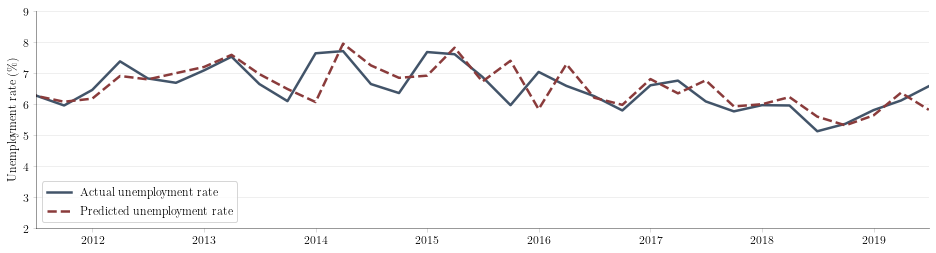

In [271]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Stockholm'
model = 'xgboost'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Actual unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted unemployment rate',
       linewidth = linewidth, linestyle = '--')


#geo = 'Stockholm'
#model = 'baseline'
#how = '_level'

#PREDICTED
#ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color ='darkgreen', label = 'Predicted baseline',
#       linewidth = linewidth, linestyle = ':')

ax.legend(fancybox = True, loc = 3)

ax.set_ylabel('Unemployment rate (\%)')
ax.set_ylim([2,9])
#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# # #Exporting
# plt.savefig("report/8_robustness_SE/8_pred_level_stockholm_weighted_v_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
# plt.show()

Max diff

In [272]:
# df_1 = df_results.dropna()[['target_actual', 'date']][df_results['ID']=='Stockholm']
# df_2 = df_results[[model+'_pred'+how, 'date']][df_results['ID']=='Stockholm']

# df_temp = df_1.merge(df_2, right_on = ['date'], left_on = ['date'])
# print(list(df_temp))
# df_temp['diff'] = df_temp['target_actual'] - df_temp['weighted_pred_level']

In [273]:
# df_temp[df_temp['diff'] == df_temp['diff'].max()]

In [274]:
# fig, ax = plt.subplots(figsize = (16,4))

# geo = 'Stockholm'
# model = 'weighted'
# how = '_diff'

# #TRUE
# ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Actual unemployment rate',
#        linewidth = linewidth)

# #PREDICTED
# ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted unemployment rate',
#        linewidth = linewidth, linestyle = '--')

# #geo = 'Stockholm'
# #model = 'baseline'
# #how = '_diff'

# #PREDICTED
# #ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color ='darkgreen', label = 'Predicted baseline',
# #       linewidth = linewidth, linestyle = ':')

# ax.legend(fancybox = True)

# ax.set_ylabel('Change in Unemployment rate (\%p)')

# #Fixing box and grids
# ax.grid(b = True, axis ='y', alpha=0.25)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_alpha(0.5)
# ax.spines['left'].set_alpha(0.5)
# ax.tick_params(axis='x', color = 'lightgrey')
# ax.tick_params(axis='y', color = 'lightgrey')
# ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# # # #Exporting
# # plt.savefig("report/8_robustness_SE/8_pred_diff_stockholm_weighted_v_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
# # plt.show()

### Average error by true target value - BAR chart - BASELINE v. xgboost

In [89]:
temp = df_results.dropna().copy()

In [90]:
#Squared errors
temp['baseline_sq_error'] = (temp['target_diff'] - temp['baseline_pred_diff'])**2
temp['weighted_sq_error'] = (temp['target_diff'] - temp['xgboost_pred_diff'])**2

In [110]:
end_points = 1
mid_point = 0.5

#For plots
baseline = []

baseline.append(temp[(temp['target_diff']<=-end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']<-mid_point) & (temp['target_diff']>-end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']<-mid_point) & (temp['target_diff']<mid_point)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>mid_point) & (temp['target_diff']<end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>=end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[0].round(2))

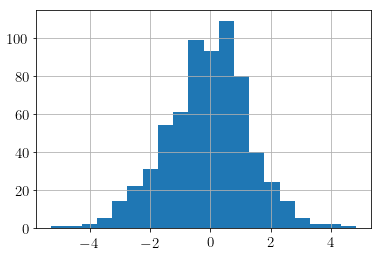

In [111]:
temp['target_diff'].hist(bins = 20)

In [112]:
weighted= []

weighted.append(temp[(temp['target_diff']<=-end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[1].round(2))

weighted.append(temp[(temp['target_diff']<-mid_point) & (temp['target_diff']>-end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[1].round(2))

weighted.append(temp[(temp['target_diff']<-mid_point) & (temp['target_diff']<mid_point)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[1].round(2))

weighted.append(temp[(temp['target_diff']>mid_point) & (temp['target_diff']<end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[1].round(2))

weighted.append(temp[(temp['target_diff']>=end_points)][['baseline_sq_error', 'weighted_sq_error']].mean().apply(np.sqrt)[1].round(2))

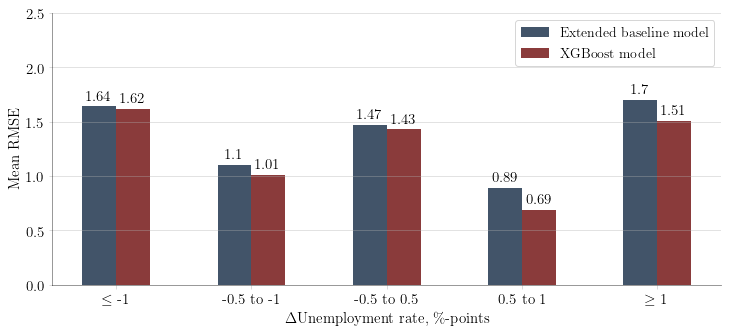

In [114]:
fig, ax = plt.subplots(figsize = (12,5))

labels = ['$\leq$ -1', '-0.5 to -1', '-0.5 to 0.5','0.5 to 1', '$\geq$ 1']

x = np.arange(len(labels))
width = 0.25

#BASELINE
rects1 = ax.bar(x - width/2, baseline, label = 'Extended baseline model', width = width, color = color_rgb[0])

#XGBOOST
rects2 = ax.bar(x + width/2, weighted, label = 'XGBoost model', width = width, color = color_rgb[4])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)


ax.set_ylabel('Mean RMSE')
ax.set_xlabel('$\Delta$Unemployment rate, \%-points')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 2.5])

ax.legend(fancybox = True, loc = 1)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/8_robustness_SE/8_error_bar.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

###  Boxplot - error

In [28]:
#ERROR
for model_str in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_results[model_str+'_error'] = (df_results['target_diff'] - df_results[model_str+'_pred_diff'])

In [29]:
boxplot_order = ['Värmland', 'Dalarna', 'Norrbotten', 'Örebro', 'Västerbotten',
       'Gävleborg', 'Halland', 'Uppsala', 'Kalmar', 'Kronoberg',
       'Västernorrland', 'Skåne', 'Västra Götalands', 'Östergötland',
       'Jönköping', 'Södermanland', 'Västmanland', 'Blekinge', 'Stockholm',
       'Gotland']

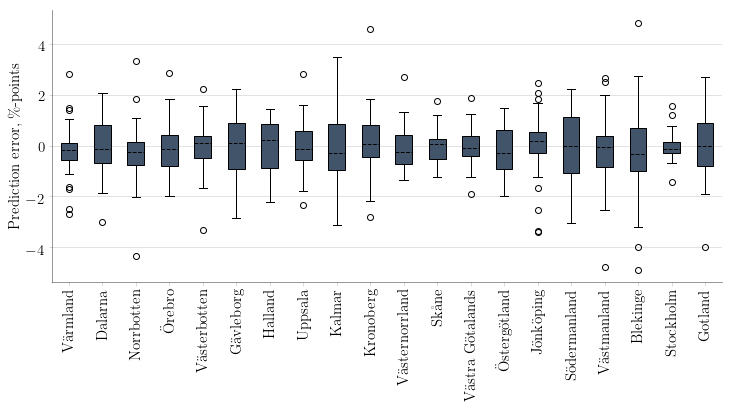

In [32]:
fig, ax = plt.subplots(figsize = (12,5))

color_rgb = [(0.26, 0.33, 0.410)]*20
model_str = 'xgboost'

data = [df_results[df_results['ID'] == geo].dropna()[model_str+'_error'] for geo in boxplot_order]
# [df_results[df_results['ID'] == 'Blekinge'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Dalarna'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Gotland'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Gävleborg'].dropna()[model_str+'_error'],
#        df_results[df_results['ID'] == 'Halland'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Jönköping'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Kalmar'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Kronoberg'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Norrbotten'].dropna()[model_str+'_error'],
#        df_results[df_results['ID'] == 'Skåne'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Stockholm'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Södermanland'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Uppsala'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Värmland'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Västerbotten'].dropna()[model_str+'_error'],
#        df_results[df_results['ID'] == 'Västernorrland'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Västmanland'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Västra Götalands'].dropna()[model_str+'_error'],
#         df_results[df_results['ID'] == 'Örebro'].dropna()[model_str+'_error'], 
#         df_results[df_results['ID'] == 'Östergötland'].dropna()[model_str+'_error']]


box = ax.boxplot(data, notch = False, bootstrap = 10000, showmeans = False, patch_artist = True) #boxprops = dict(medianprops='black')

for patch, color in zip(box['boxes'], color_rgb):
    patch.set_facecolor(color)
    

for patch, color in zip(box['medians'], ['black']*20):
    patch.set_color(color)
    patch.set_linestyle('--')


ax.set_xticklabels(boxplot_order,rotation='vertical')


ax.set_ylabel('Prediction error, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/8_robustness_SE/8_regional_boxplot_xgboost.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [53]:
print(df_analysis.groupby(['ID'])['population'].mean()/1000)

ID
Blekinge             154.134431
Dalarna              278.770765
Gotland               57.479490
Gävleborg            278.814353
Halland              305.063765
Jönköping            341.692569
Kalmar               235.970902
Kronoberg            187.030804
Norrbotten           249.896431
Skåne               1262.614353
Stockholm           2114.130451
Södermanland         275.850686
Uppsala              342.115275
Värmland             274.998667
Västerbotten         261.285647
Västernorrland       243.522863
Västmanland          257.907078
Västra Götalands    1606.265235
Örebro               284.759784
Östergötland         435.579078
Name: population, dtype: float64


### Relative gain in RMSE - across regions

In [35]:
temp = df_results.drop(['weighted_pred_diff', 'weighted_pred_level', 'weighted_error'], axis = 1).dropna().copy()

In [36]:
#Squared errors
temp['baseline_sq_error'] = (temp['target_diff'] - temp['baseline_pred_diff'])**2
temp['xgboost_sq_error'] = (temp['target_diff'] - temp['xgboost_pred_diff'])**2

In [37]:
temp_plot = temp.groupby('ID')[['baseline_sq_error','xgboost_sq_error']].mean().apply(np.sqrt)

In [38]:
# temp_plot['relative_mean_rmse'] = ((temp_plot['baseline_sq_error'] - temp_plot['xgboost_sq_error']) / temp_plot['baseline_sq_error']*100).round(0).astype(int)
temp_plot['relative_mean_rmse'] = ((temp_plot['baseline_sq_error'] - temp_plot['xgboost_sq_error'])).round(4)

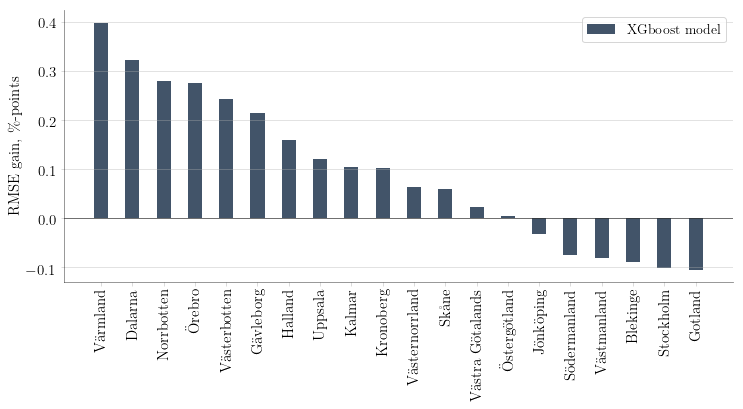

In [39]:
fig, ax = plt.subplots(figsize = (12,5))

labels = list(temp_plot.sort_values('relative_mean_rmse', ascending=False).index)

x = np.arange(len(labels))
width = 0.45

#XGBOOST
rects = ax.bar(x, list(temp_plot.sort_values('relative_mean_rmse', ascending=False)['relative_mean_rmse']), label = 'XGboost model', width = width, color = color_rgb[0])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects)


ax.set_ylabel('RMSE gain, \%-points')
# ax.set_xlabel('')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
# ax.set_ylim([0, 2.5])
ax.axhline(y=0, color = 'black', linewidth=0.5)

ax.legend(fancybox = True, loc = 1)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/8_robustness_SE/8_regional_gain.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [314]:
temp_plot[temp_plot['relative_mean_rmse']>0]

,baseline_sq_error,xgboost_sq_error,relative_mean_rmse
ID,,,
Dalarna,1.411827,1.089958,0.3219
Gävleborg,1.541849,1.328048,0.2138
Halland,1.137138,0.977676,0.1595
Kalmar,1.455563,1.351156,0.1044
Kronoberg,1.432086,1.330552,0.1015
Norrbotten,1.526415,1.246604,0.2798
Skåne,0.773905,0.713601,0.0603
Uppsala,1.138992,1.019094,0.1199
Värmland,1.480408,1.081777,0.3986


### Number of times beating baseline - across regions

In [166]:
temp = df_results.drop(['weighted_pred_diff', 'weighted_pred_level', 'weighted_error'], axis = 1).dropna().copy()

In [167]:
#Squared errors
temp['baseline_sq_error'] = (temp['target_diff'] - temp['baseline_pred_diff'])**2
temp['xgboost_sq_error'] = (temp['target_diff'] - temp['xgboost_pred_diff'])**2

In [168]:
#Relative to baseline
temp['xgboost_below'] = temp['xgboost_sq_error'] < temp['baseline_sq_error']

In [171]:
temp_plot = (temp.groupby('ID')['xgboost_below'].sum() / temp['win'].nunique())

In [174]:
temp_plot.sort_values()

ID
Östergötland        0.411765
Västernorrland      0.441176
Blekinge            0.441176
Uppsala             0.470588
Stockholm           0.470588
Skåne               0.500000
Dalarna             0.500000
Halland             0.529412
Västra Götalands    0.529412
Södermanland        0.558824
Kronoberg           0.588235
Gävleborg           0.588235
Norrbotten          0.617647
Gotland             0.617647
Kalmar              0.617647
Västmanland         0.617647
Örebro              0.617647
Jönköping           0.647059
Västerbotten        0.676471
Värmland            0.764706
Name: xgboost_below, dtype: float64

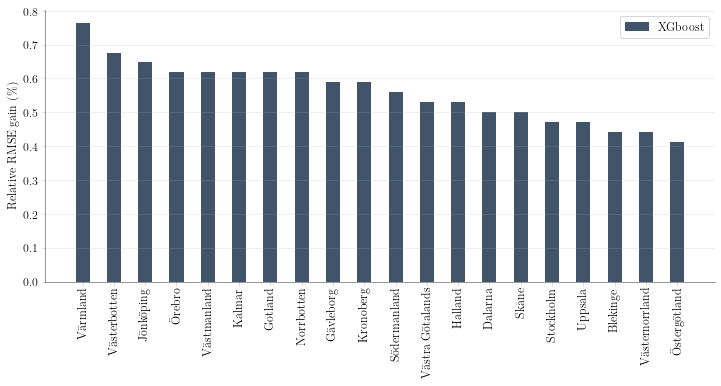

In [176]:
fig, ax = plt.subplots(figsize = (12,5))

labels = list(temp_plot.sort_values(ascending=False).index)

x = np.arange(len(labels))
width = 0.45

#XGBOOST
rects = ax.bar(x, list(temp_plot.sort_values(ascending=False)), label = 'XGboost', width = width, color = color_rgb[0])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects)


ax.set_ylabel('Relative RMSE gain (\%)')
# ax.set_xlabel('')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
# ax.set_ylim([0, 2.5])
ax.axhline(y=0, color = 'black', linewidth=0.5)

ax.legend(fancybox = True, loc = 1)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
# plt.savefig("report/8_robustness_SE/8_regional_gain.pdf", bbox_inches='tight', encoding='utf-8-sig')
# plt.show()

### Confidence intervals

In [41]:
#loading boot pickle
with open('results/final/bootstrap/results_bootstrap.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
for win in results.keys():
    del results[win]['bootstrap_results']

In [42]:
results_model_lower = {}
results_model_upper = {}

results_ar_lower = {}
results_ar_upper = {}

lower = 2.5
upper = 97.5

for win in results.keys():

    results_model_lower[win] = np.percentile([results[win][boot]['rmse_model'] for boot in results[win].keys()], lower)
    results_model_upper[win] = np.percentile([results[win][boot]['rmse_model'] for boot in results[win].keys()], upper)
    
    results_ar_lower[win] = np.percentile([results[win][boot]['rmse_ar'] for boot in results[win].keys()], lower)
    results_ar_upper[win] = np.percentile([results[win][boot]['rmse_ar'] for boot in results[win].keys()], upper)
    
 

In [43]:
conf = pd.DataFrame.from_dict({'model_lower' : results_model_lower,
                        'model_upper' : results_model_upper,
                       'ar_lower' : results_ar_lower,
                       'ar_upper' : results_ar_upper},
                       orient='columns')

conf.reset_index(inplace = True)


conf.rename({'index': 'win'}, axis = 1, inplace = True)

df_score = pd.merge(df_score, conf, how = 'left', on = 'win').copy()

In [44]:
df_score.columns

Index(['date', 'win', 'baseline_rmse', 'lasso_rmse', 'ridge_rmse',
       'elastic_rmse', 'randomforest_rmse', 'xgboost_rmse', 'weighted_rmse',
       'baseline_relative', 'lasso_relative', 'ridge_relative',
       'elastic_relative', 'randomforest_relative', 'xgboost_relative',
       'weighted_relative', 'lasso_below', 'ridge_below', 'elastic_below',
       'randomforest_below', 'xgboost_below', 'weighted_below', 'model_lower',
       'model_upper', 'ar_lower', 'ar_upper'],
      dtype='object')

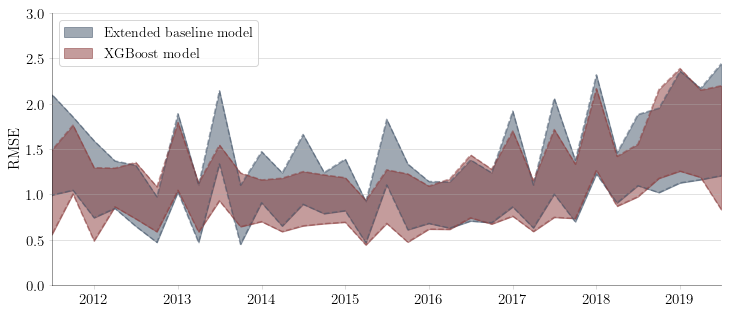

In [57]:
fig, ax = plt.subplots(figsize = (12,5))

alpha = 0.5


color = (0.26, 0.33, 0.41)
#BASELINE
# ax.plot(df_score[['baseline_rmse', 'date']].set_index('date'), color = color, label = 'Baseline',  marker = '.')
ax.plot(df_score[['ar_lower', 'date']].set_index('date'), color = color, alpha = alpha, linestyle = '--')
ax.plot(df_score[['ar_upper', 'date']].set_index('date'), color = color, alpha = alpha, linestyle = '--')
ax.fill_between(df_score['date'], df_score['ar_lower'], df_score['ar_upper'],
                color = color, alpha = alpha, label ='Extended baseline model')


color = (0.54, 0.23, 0.23)
#XGBOOST
# ax.plot(df_score[['xgboost_rmse', 'date']].set_index('date'), color = color, label = 'XGBoost',  marker = '.')
ax.plot(df_score[['model_lower', 'date']].set_index('date'), color = color, alpha = alpha, linestyle = '--')
ax.plot(df_score[['model_upper', 'date']].set_index('date'), color = color, alpha = alpha, linestyle = '--')
ax.fill_between(df_score['date'], df_score['model_lower'], df_score['model_upper'],
                color = color, alpha = alpha, label = 'XGBoost model')



ax.legend(fancybox = True, loc = 2)

ax.set_ylabel('RMSE')
ax.set_ylim([0,3])
# #Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(),df_score.dropna()['date'].max())
# #Exporting
plt.savefig("report/8_robustness_SE/8_conf.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [132]:
df_score[['date', 'ar_lower', 'ar_upper']]

,date,ar_lower,ar_upper
0,2011-04-01,0.690128,1.171871
1,2011-07-01,0.953405,2.031072
2,2011-10-01,1.022371,1.860995
3,2012-01-01,0.717711,1.588406
4,2012-04-01,0.870903,1.372055
5,2012-07-01,0.643818,1.296522
6,2012-10-01,0.464891,0.966776
7,2013-01-01,1.028420,1.849919
8,2013-04-01,0.468775,1.096326
9,2013-07-01,1.325280,2.118473
